In [162]:
import numpy as np
import math

import pandas as pd
from fastparquet import ParquetFile,write
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from cm2df import cm2df,precision_recall_fscore_support_metrics2df
from sklearn.metrics import confusion_matrix, classification_report

In [163]:
pf=ParquetFile('subset_feature_4ML_110619.parq')
udf=pf.to_pandas()

In [164]:
udf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32880 entries, 11049447 to 9968570
Data columns (total 35 columns):
category                 32880 non-null int64
past                     32880 non-null int32
votes                    32880 non-null int64
is_eventbrite            32880 non-null int32
is_free                  32880 non-null int32
doors                    32880 non-null int32
sold_out                 32880 non-null int32
venue.id                 32880 non-null int64
venue.popularity         32880 non-null float64
venue.zip                32880 non-null int64
ticket_allages           32880 non-null int32
ticket_price_low         32880 non-null float64
ticket_price_max         32880 non-null float64
min_age                  32880 non-null int32
artist.popularity.sum    32880 non-null float64
artist.popularity.avg    32880 non-null float64
artist.popularity.max    32880 non-null float64
dow                      32880 non-null int64
doy                      32880 non-null in

In [165]:
usecolsX=['category', 'past', 'is_eventbrite', 'is_free', 'doors',
       'sold_out', 'venue.id', 'venue.popularity', 'venue.zip',
       'ticket_allages', 'ticket_price_low', 'ticket_price_max', 'min_age',
       'artist.popularity.sum', 'artist.popularity.avg',
       'artist.popularity.max', 'dow', 'doy', 'month', 'day', 'hour',
       'venue.tol_num_events', 'duration', 'duration_day', 'multiday']
usecoly1=['votes']
usecoly2=['avg_votes_pday']

In [166]:
udf_X=udf[usecolsX]
udf_y=udf[usecoly1]

In [167]:
# scaling of the features
from sklearn.preprocessing import MinMaxScaler
# scale regression dataset
scalar = MinMaxScaler()
scalar.fit(udf_X)
X = scalar.transform(udf_X)

In [8]:
# a function to create udf_y based on 3 classes: low, mid, high
def get_class(df,thre1,thre2):
    n=len(df)
    newdf=[]
    cut1=min([thre1,thre2])
    cut2=max([thre1,thre2])
    for item in df:
        if item<cut1: newdf+=[0]
        elif (item<cut2) and (item>=cut1):newdf+=[1]
        else: newdf+=[2]
    return newdf

In [15]:
y=get_class(udf_y.values,80,300)

In [44]:
# import algorithms for model comparisons
# tree models
from sklearn.ensemble import RandomForestClassifier

# NN models
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# linear models: SVC 
from sklearn.svm import SVC
# knn
from sklearn.neighbors import KNeighborsClassifier
# boosting
from sklearn.ensemble import AdaBoostClassifier


from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,classification_report
from sklearn.model_selection import train_test_split


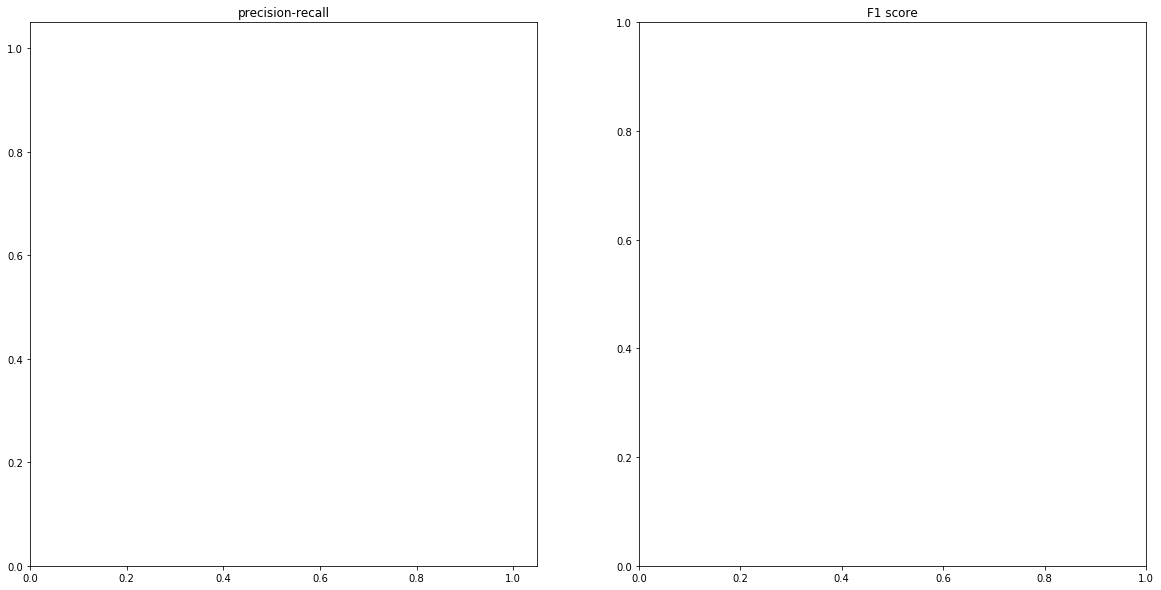

In [21]:
# test on different models based on the optimum divide : low-votes=below 80 votes, mid-votes=between 80 and 300, high-votes=above 300 votes
f1_rec=[]
prec_rec=[]
recal_rec=[]

# set up matplot figure
fig =plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('precision-recall')
ax1.set_xlim([0,1.05])
ax1.set_ylim([0,1.05])
ax2.title.set_text('F1 score')
# preset color scale
NUM_COLORS = 5
colors = cm.rainbow(np.linspace(0, 1, NUM_COLORS))
ct=0# counter for colors

# setup the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=12)


## Benchmark Model: Random Forest> 

In [22]:
classifier=RandomForestClassifier(n_estimators=20,random_state=12,verbose=0)
classifier.fit(X_train,y_train)
pred_y_test=classifier.predict(X_test)
# assess the model performance: obtain prescision/recall/f1 scores
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
f1_rec+=[adjf1]


In [25]:
# print confusion matrix
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9454   27    2]
 [ 224   89    5]
 [  36   16   11]]
other metrics:               precision    recall  f1-score   support

           0       0.97      1.00      0.98      9483
           1       0.67      0.28      0.40       318
           2       0.61      0.17      0.27        63

    accuracy                           0.97      9864
   macro avg       0.75      0.48      0.55      9864
weighted avg       0.96      0.97      0.96      9864



#### Test the Neural-Network model

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=12)
# formulate y data (specifically required by NN model)
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)


In [94]:
nfeature=len(udf_X.columns)
Nmodel=Sequential()
Nmodel.add(Dense(nfeature+5,input_dim=X_train.shape[1], activation='relu'))
Nmodel.add(Dense(nfeature+5, activation='relu'))
#Nmodel.add(Dense(nfeature, activation='relu'))
Nmodel.add(Dense(nfeature-5, activation='relu'))
Nmodel.add(Dense(3, activation='softmax'))

In [95]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m,precision_m, recall_m])

In [96]:
Nmodel.fit(X_train, dummy_y, epochs=10)

Epoch 1/10
23016/23016 [==============================] - ETA: 2s - loss: 1.1725 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+0 - ETA: 0s - loss: 0.5701 - f1_m: 0.6414 - precision_m: 0.7071 - recall_m: 0.6259            - ETA: 0s - loss: 0.4024 - f1_m: 0.7812 - precision_m: 0.8181 - recall_m: 0.772 - ETA: 0s - loss: 0.3428 - f1_m: 0.8281 - precision_m: 0.8556 - recall_m: 0.821 - ETA: 0s - loss: 0.3071 - f1_m: 0.8532 - precision_m: 0.8756 - recall_m: 0.848 - ETA: 0s - loss: 0.2857 - f1_m: 0.8701 - precision_m: 0.8889 - recall_m: 0.865 - ETA: 0s - loss: 0.2690 - f1_m: 0.8822 - precision_m: 0.8986 - recall_m: 0.878 - ETA: 0s - loss: 0.2536 - f1_m: 0.8933 - precision_m: 0.9073 - recall_m: 0.890 - ETA: 0s - loss: 0.2400 - f1_m: 0.9024 - precision_m: 0.9146 - recall_m: 0.899 - ETA: 0s - loss: 0.2281 - f1_m: 0.9097 - precision_m: 0.9205 - recall_m: 0.907 - ETA: 0s - loss: 0.2239 - f1_m: 0.9136 - precision_m: 0.9236 - recall_m: 0.911 - ETA: 0s - loss: 0.2189 - f1_m: 0.9166 

In [97]:
pred_y_test = Nmodel.predict(X_test)
pred_y_testNN = np.argmax(pred_y_test,axis=1) 

In [98]:
a=precision_recall_fscore_support(y_test, list(pred_y_testNN))
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
f1_rec+=[adjf1]

In [99]:
# print confusion matrix
print("confusion matrix:",confusion_matrix(y_test, pred_y_testNN))
print("other metrics:",classification_report(y_test, pred_y_testNN))

confusion matrix: [[9455   25    3]
 [ 289   27    2]
 [  53   10    0]]
other metrics:               precision    recall  f1-score   support

           0       0.97      1.00      0.98      9483
           1       0.44      0.08      0.14       318
           2       0.00      0.00      0.00        63

    accuracy                           0.96      9864
   macro avg       0.47      0.36      0.37      9864
weighted avg       0.94      0.96      0.95      9864



#### Test the SVC model

In [100]:
classifier=SVC(random_state=12,verbose=0)
classifier.fit(X_train,y_train)
pred_y_test=classifier.predict(X_test)

C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [101]:
a=precision_recall_fscore_support(y_test, list(pred_y_test))
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
f1_rec+=[adjf1]

C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [102]:
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9483    0    0]
 [ 318    0    0]
 [  63    0    0]]
other metrics:               precision    recall  f1-score   support

           0       0.96      1.00      0.98      9483
           1       0.00      0.00      0.00       318
           2       0.00      0.00      0.00        63

    accuracy                           0.96      9864
   macro avg       0.32      0.33      0.33      9864
weighted avg       0.92      0.96      0.94      9864



### Test KNN model

In [158]:
classifier=KNeighborsClassifier(n_neighbors=15)
classifier.fit(X_train,y_train)
pred_y_test=classifier.predict(X_test)

In [159]:
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
#prec_rec+=[a[0]]
#recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
#f1_rec+=[adjf1]
print(adjf1)

0.2430792850670925


In [160]:
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9463   20    0]
 [ 270   46    2]
 [  61    2    0]]
other metrics:               precision    recall  f1-score   support

           0       0.97      1.00      0.98      9483
           1       0.68      0.14      0.24       318
           2       0.00      0.00      0.00        63

    accuracy                           0.96      9864
   macro avg       0.55      0.38      0.41      9864
weighted avg       0.95      0.96      0.95      9864



#### Test the Adaboost model

In [118]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [125]:
classifier=AdaBoostClassifier(n_estimators=25,random_state=12)
classifier.fit(X_train,y_train)
pred_y_test=classifier.predict(X_test)

In [126]:
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)
#f1_rec+=[adjf1]

0.30625744461572224


In [127]:
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9424   55    4]
 [ 276   40    2]
 [  46   11    6]]
other metrics:               precision    recall  f1-score   support

           0       0.97      0.99      0.98      9483
           1       0.38      0.13      0.19       318
           2       0.50      0.10      0.16        63

    accuracy                           0.96      9864
   macro avg       0.61      0.40      0.44      9864
weighted avg       0.94      0.96      0.95      9864



In [115]:
f1_rec

[0.43181191505617195,
 0.19243612015978875,
 0.21083660915774913,
 0.16338450405747662,
 0.3486952940466144,
 0.30625744461572224]

#### Test XGBoost Method

In [129]:
import xgboost as xgb

In [153]:
dtrain = xgb.DMatrix(X_train, label=y_train,feature_names=udf_X.columns.values)
dtest = xgb.DMatrix(X_test, label=y_test,feature_names=udf_X.columns.values)

In [132]:
my_params={'eta':0.3,'seed':12,'objective':'multi:softprob','max_depth':4,'num_class': 3}
num_round = 20

In [154]:
bst = xgb.train(my_params, dtrain, num_round)

In [155]:
pred_y_test_prd = bst.predict(dtest)

In [140]:
pred_y_test_prd

array([[0.9839024 , 0.01182538, 0.00427221],
       [0.9926958 , 0.00479091, 0.00251333],
       [0.9662614 , 0.02661434, 0.00712425],
       ...,
       [0.96808887, 0.02441883, 0.00749237],
       [0.9881875 , 0.0077579 , 0.00405459],
       [0.99267936, 0.00519996, 0.00212075]], dtype=float32)

In [156]:
pred_y_test = np.asarray([np.argmax(line) for line in pred_y_test_prd])

In [144]:
a=precision_recall_fscore_support(y_test, pred_y_test)
f1s=a[2]
prec_rec+=[a[0]]
recal_rec+=[a[1]]
# create the weighted f1 score: larger emphasis on high-votes bin and medium
# adjusted f1_forall= (f1_low+f1_mid*2+f1_high*3)/6
adjf1=(f1s[0]+f1s[1]*2+f1s[2]*3)/6
print(adjf1)
#f1_rec+=[adjf1]

0.37318864455567985


In [146]:
print("confusion matrix:",confusion_matrix(y_test, pred_y_test))
print("other metrics:",classification_report(y_test, pred_y_test))

confusion matrix: [[9460   20    3]
 [ 236   77    5]
 [  41   15    7]]
other metrics:               precision    recall  f1-score   support

           0       0.97      1.00      0.98      9483
           1       0.69      0.24      0.36       318
           2       0.47      0.11      0.18        63

    accuracy                           0.97      9864
   macro avg       0.71      0.45      0.51      9864
weighted avg       0.96      0.97      0.96      9864



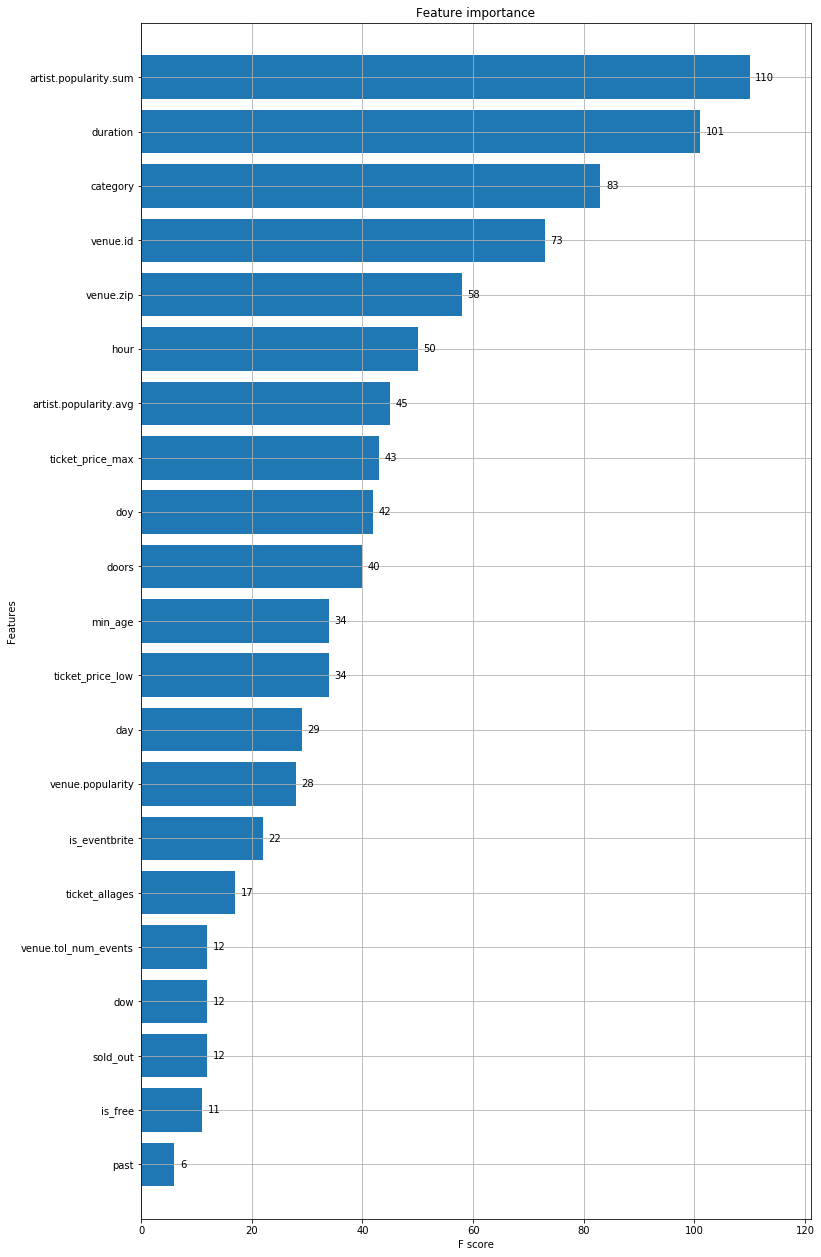

In [157]:
# take a look at the feature importances suggested by xgboost
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12,22))
xgb.plot_importance(bst, max_num_features=25, height=0.8, ax=ax)
plt.show()

In [161]:
# Taking a look at the f1 score performance (weighted) for all models:
print("f1 weighted score for Random Forest:",f1_rec[0])
print("f1 weighted score for Neural-Network 4 layers:",f1_rec[1])
print("f1 weighted score for linear SVC-model:",f1_rec[2])
print("f1 weighted score for KNearest Neighbor(k=15):",f1_rec[3])
print("f1 weighted score for Adaboost:",f1_rec[4])
print("f1 weighted score for XGboost:",f1_rec[5])

f1 weighted score for Random Forest: 0.43181191505617195
f1 weighted score for Neural-Network 4 layers: 0.19243612015978875
f1 weighted score for linear SVC-model: 0.21083660915774913
f1 weighted score for KNearest Neighbor(k=15): 0.16338450405747662
f1 weighted score for Adaboost: 0.3486952940466144
f1 weighted score for XGboost: 0.30625744461572224
